In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

C:\anaconda\envs\tenserflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\anaconda\envs\tenserflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\anaconda\envs\tenserflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\anaconda\envs\tenserflow\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWa

In [5]:
INIT_LR = 1e-4
EPOCHS = 25
BS = 32

DIRECTORY = r"C:\Users\neeraj\Documents\jupyternotebook\ml\numberplate detection\train\train"
CATEGORIES = ["with_mask", "without_mask"]

In [6]:
print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


In [7]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.22, stratify=labels, random_state=42)

In [9]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\anaconda\envs\tenserflow\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
for layer in baseModel.layers:layer.trainable = False

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [14]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
36/36 [==============================] - 25s 692ms/step - loss: 0.6761 - acc: 0.6236 - val_loss: 0.4340 - val_acc: 0.7771
Epoch 2/25
36/36 [==============================] - 24s 664ms/step - loss: 0.4000 - acc: 0.8253 - val_loss: 0.2455 - val_acc: 0.9307
Epoch 3/25
36/36 [==============================] - 28s 785ms/step - loss: 0.3208 - acc: 0.8715 - val_loss: 0.1766 - val_acc: 0.9639
Epoch 4/25
36/36 [==============================] - 33s 928ms/step - loss: 0.2380 - acc: 0.9121 - val_loss: 0.1533 - val_acc: 0.9578
Epoch 5/25
36/36 [==============================] - 45s 1s/step - loss: 0.2096 - acc: 0.9153 - val_loss: 0.1254 - val_acc: 0.9729
Epoch 6/25
36/36 [==============================] - 50s 1s/step - loss: 0.1915 - acc: 0.9249 - val_loss: 0.0942 - val_acc: 0.9910
Epoch 7/25
36/36 [==============================] - 52s 1s/step - loss: 0.1779 - acc: 0.9336 - val_loss: 0.1117 - 

In [24]:
predIdxs = model.predict(testX, batch_size=BS)

In [25]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")


              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       166
without_mask       1.00      0.98      0.99       166

    accuracy                           0.99       332
   macro avg       0.99      0.99      0.99       332
weighted avg       0.99      0.99      0.99       332

[INFO] saving mask detector model...


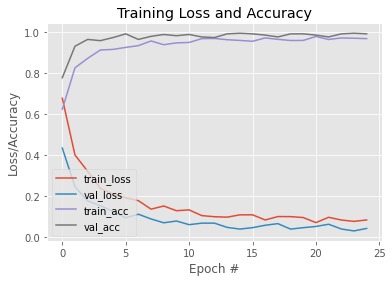

In [26]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [27]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

In [28]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()
    print(detections.shape)

    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)

In [29]:
prototxtPath = r"C:\Users\neeraj\Documents\jupyternotebook\ml\numberplate detection\deploy.prototxt"
weightsPath = r"C:\Users\neeraj\Documents\jupyternotebook\ml\numberplate detection\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

In [30]:
maskNet = load_model(r"C:\Users\neeraj\Documents\jupyternotebook\ml\numberplate detection\mask_detector.model")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [38]:
# initialize the video stream
vs = VideoStream(src=0).start()

In [39]:
while True:
    frame = vs.read()
    frame = imutils.resize(frame, width=1000)

    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 4)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 4)

# show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `s` key was pressed, break from the loop
    if key == ord("s"):
        break

(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200

(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200

In [40]:
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

In [41]:
VideoStream(src=0).stop()